In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285388 sha256=2f27aa9fc4c982cc54e0e4918767d906e14bb76fca49d0d8ece4b05fc228f3e0
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from itertools import combinations

import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from itertools import combinations

from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.sql.functions import col, log1p, mean
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit


from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor, GBTRegressor

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor


from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor, DecisionTreeRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pyspark.sql.functions import col

In [ ]:
# Initialize a Spark session
spark = SparkSession.builder.appName("BigMartRegression").getOrCreate()

In [ ]:
# Load the dataset
data_path = r"C:\Users\charu\project\BM_train\BM_Train.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

In [ ]:
# Fill null values in "Outlet_Size" column with "small"
df_filled = df.fillna({"Outlet_Size": "small"})

In [ ]:
# Display basic information about the dataset
df.printSchema()
print("Number of rows:", df.count())
print("Columns:", df.columns)

root
 |-- Item_Identifier: string (nullable = true)
 |-- Item_Weight: double (nullable = true)
 |-- Item_Fat_Content: string (nullable = true)
 |-- Item_Visibility: double (nullable = true)
 |-- Item_Type: string (nullable = true)
 |-- Item_MRP: double (nullable = true)
 |-- Outlet_Identifier: string (nullable = true)
 |-- Outlet_Establishment_Year: integer (nullable = true)
 |-- Outlet_Size: string (nullable = true)
 |-- Outlet_Location_Type: string (nullable = true)
 |-- Outlet_Type: string (nullable = true)
 |-- Item_Outlet_Sales: double (nullable = true)

Number of rows: 8523
Columns: ['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales']


In [ ]:
# Summary statistics for numerical variables
num_summary = df.describe().select("summary", "Item_Weight", "Item_MRP", "Item_Outlet_Sales")
num_summary.show()

+-------+------------------+-----------------+------------------+
|summary|       Item_Weight|         Item_MRP| Item_Outlet_Sales|
+-------+------------------+-----------------+------------------+
|  count|              7060|             8523|              8523|
|   mean|12.857645184136183|140.9927819781768|2181.2889135750365|
| stddev| 4.643456499186414|62.27506651219047|1706.4996157338403|
|    min|             4.555|            31.29|             33.29|
|    max|             21.35|         266.8884|        13086.9648|
+-------+------------------+-----------------+------------------+



array([[<Axes: title={'center': 'Item_Weight'}>,
        <Axes: title={'center': 'Item_MRP'}>],
       [<Axes: title={'center': 'Item_Outlet_Sales'}>, <Axes: >]],
      dtype=object)

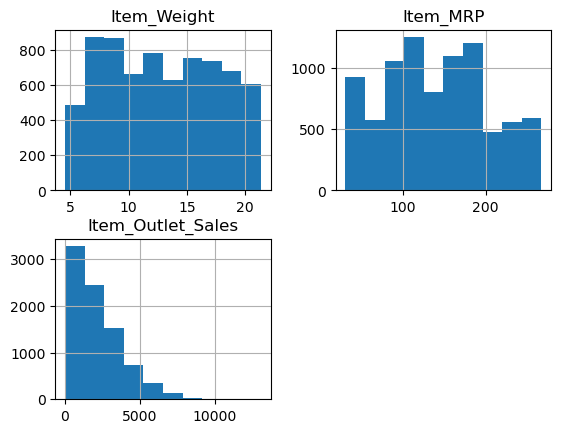

In [ ]:
# Data Exploration - histograms for numerical variables
num_vars = ["Item_Weight", "Item_MRP", "Item_Outlet_Sales"]
df.select(num_vars).toPandas().hist()

In [ ]:
# Data Exploration - frequency distribution for categorical variables
cat_vars = ["Item_Fat_Content", "Item_Type", "Outlet_Size"]
for var in cat_vars:
    df.groupBy(var).count().orderBy(col("count").desc()).show()

+----------------+-----+
|Item_Fat_Content|count|
+----------------+-----+
|         Low Fat| 5089|
|         Regular| 2889|
|              LF|  316|
|             reg|  117|
|         low fat|  112|
+----------------+-----+

+--------------------+-----+
|           Item_Type|count|
+--------------------+-----+
|Fruits and Vegeta...| 1232|
|         Snack Foods| 1200|
|           Household|  910|
|        Frozen Foods|  856|
|               Dairy|  682|
|              Canned|  649|
|        Baking Goods|  648|
|  Health and Hygiene|  520|
|         Soft Drinks|  445|
|                Meat|  425|
|              Breads|  251|
|         Hard Drinks|  214|
|              Others|  169|
|       Starchy Foods|  148|
|           Breakfast|  110|
|             Seafood|   64|
+--------------------+-----+

+-----------+-----+
|Outlet_Size|count|
+-----------+-----+
|     Medium| 2793|
|       null| 2410|
|      Small| 2388|
|       High|  932|
+-----------+-----+



In [ ]:


# Handling Missing Values
missing_counts = df.select([F.count(F.col(c).isNull()).alias(c + "_missing") for c in df.columns])
missing_counts.show()

+-----------------------+-------------------+------------------------+-----------------------+-----------------+----------------+-------------------------+---------------------------------+-------------------+----------------------------+-------------------+-------------------------+
|Item_Identifier_missing|Item_Weight_missing|Item_Fat_Content_missing|Item_Visibility_missing|Item_Type_missing|Item_MRP_missing|Outlet_Identifier_missing|Outlet_Establishment_Year_missing|Outlet_Size_missing|Outlet_Location_Type_missing|Outlet_Type_missing|Item_Outlet_Sales_missing|
+-----------------------+-------------------+------------------------+-----------------------+-----------------+----------------+-------------------------+---------------------------------+-------------------+----------------------------+-------------------+-------------------------+
|                   8523|               8523|                    8523|                   8523|             8523|            8523|                

In [ ]:
# import pyspark.sql.functions as F
# import tabulate

# # Handling Missing Values
# missing_counts = df.select([F.count(F.col(c).isNull()).alias(c + "_missing") for c in df.columns])

# # Convert the DataFrame to a Pandas DataFrame
# df_pandas = missing_counts.toPandas()

# # Print the table in a nice format
# print(tabulate(df_pandas, headers=df_pandas.columns, tablefmt="pipe"))

In [ ]:



# Handling Missing Values and Identifying Columns with Missing Values
missing_counts = df.select([sum(col(c).isNull().cast("int")).alias(c + "_missing") for c in df.columns])
missing_counts.show()

# Identify columns with missing values
missing_cols = [c for c in missing_counts.columns if "_missing" in c]
print("Columns with missing values:", missing_cols)

+-----------------------+-------------------+------------------------+-----------------------+-----------------+----------------+-------------------------+---------------------------------+-------------------+----------------------------+-------------------+-------------------------+
|Item_Identifier_missing|Item_Weight_missing|Item_Fat_Content_missing|Item_Visibility_missing|Item_Type_missing|Item_MRP_missing|Outlet_Identifier_missing|Outlet_Establishment_Year_missing|Outlet_Size_missing|Outlet_Location_Type_missing|Outlet_Type_missing|Item_Outlet_Sales_missing|
+-----------------------+-------------------+------------------------+-----------------------+-----------------+----------------+-------------------------+---------------------------------+-------------------+----------------------------+-------------------+-------------------------+
|                      0|               1463|                       0|                      0|                0|               0|                

In [ ]:
# print(tabulate(df_pandas, headers=df_pandas.columns, tablefmt="pipe", floatfmt=".2f"))

In [ ]:
import pyspark.sql.functions as F
import pandas as pd
from tabulate import tabulate

# Handling Missing Values
# missing_counts = df.select([F.count(F.col(c).isNull()).alias(c + "_missing") for c in df.columns])

# Convert the DataFrame to a Pandas DataFrame
df_pandas = missing_counts.toPandas()

# Transpose the DataFrame
df_pandas_transposed = df_pandas.T

# Print the table in a nice format
print(tabulate(df_pandas_transposed, headers=df_pandas_transposed.index, tablefmt="pipe"))

| Item_Identifier_missing           |   Item_Weight_missing |
|:----------------------------------|----------------------:|
| Item_Identifier_missing           |                     0 |
| Item_Weight_missing               |                  1463 |
| Item_Fat_Content_missing          |                     0 |
| Item_Visibility_missing           |                     0 |
| Item_Type_missing                 |                     0 |
| Item_MRP_missing                  |                     0 |
| Outlet_Identifier_missing         |                     0 |
| Outlet_Establishment_Year_missing |                     0 |
| Outlet_Size_missing               |                  2410 |
| Outlet_Location_Type_missing      |                     0 |
| Outlet_Type_missing               |                     0 |
| Item_Outlet_Sales_missing         |                     0 |


In [ ]:
# # Dealing with Outliers - Visualization
# num_vars = ["Item_Weight", "Item_MRP", "Item_Outlet_Sales"]  # Adjust as needed
# num_df = df.select(num_vars).toPandas()

# # Box plots for visualization
# plt.figure(figsize=(12, 6))
# sns.boxplot(data=num_df)
# plt.xticks(rotation=45)
# plt.title("Box Plot for Numerical Variables")
# plt.show()

# # Domain Knowledge-based Outlier Treatment
# # Analyze box plot results and decide on outlier treatment strategies
# # Examples of strategies: Winsorizing, log transformation, capping values, removing extreme outliers


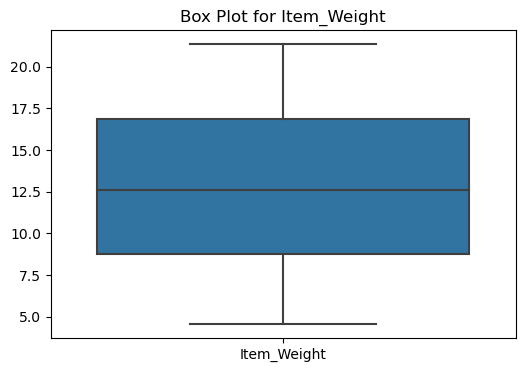

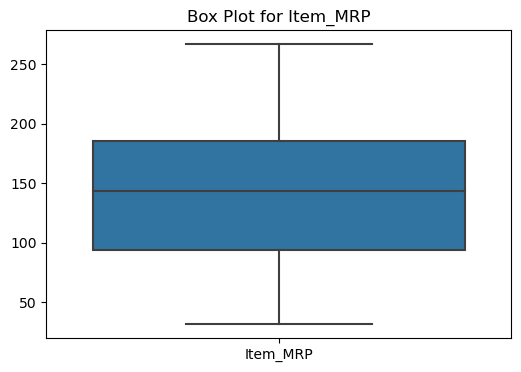

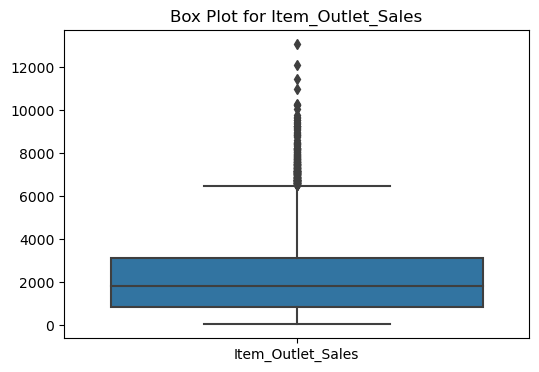

In [ ]:
# Dealing with Outliers - Visualization
num_vars = ["Item_Weight", "Item_MRP", "Item_Outlet_Sales"]  # Adjust as needed

# Create separate box plots for each numerical variable
for var in num_vars:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df.select(var).toPandas())
    plt.title(f"Box Plot for {var}")
    plt.show()

In [ ]:
# Select numerical columns for correlation calculation
numerical_cols = ["Item_Weight", "Item_Visibility", "Item_MRP", "Item_Outlet_Sales","Outlet_Establishment_Year"]

# Filter the DataFrame to include only numerical columns
numerical_df = df.select(*numerical_cols)

# Calculate pairwise correlations
correlations = []
for col1, col2 in combinations(numerical_cols, 2):
    corr_value = numerical_df.stat.corr(col1, col2)
    correlations.append((col1, col2, corr_value))

# Display the pairwise correlations
for col1, col2, corr_value in correlations:
    print(f"Correlation between {col1} and {col2}: {corr_value}")

Correlation between Item_Weight and Item_Visibility: -0.07752195971024756
Correlation between Item_Weight and Item_MRP: 0.02285866523517781
Correlation between Item_Weight and Item_Outlet_Sales: -0.05322227785889025
Correlation between Item_Weight and Outlet_Establishment_Year: 0.5205608105209867
Correlation between Item_Visibility and Item_MRP: -0.0013148480362671618
Correlation between Item_Visibility and Item_Outlet_Sales: -0.12862461222076968
Correlation between Item_Visibility and Outlet_Establishment_Year: -0.07483350421024908
Correlation between Item_MRP and Item_Outlet_Sales: 0.5675744466569178
Correlation between Item_MRP and Outlet_Establishment_Year: 0.005019916170231697
Correlation between Item_Outlet_Sales and Outlet_Establishment_Year: -0.049134970440820575


C:\Users\ArvindDS\AppData\Local\Temp\ipykernel_30580\3048251208.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  correlation_matrix = correlation_matrix_df.pivot("Column1", "Column2", "Correlation")


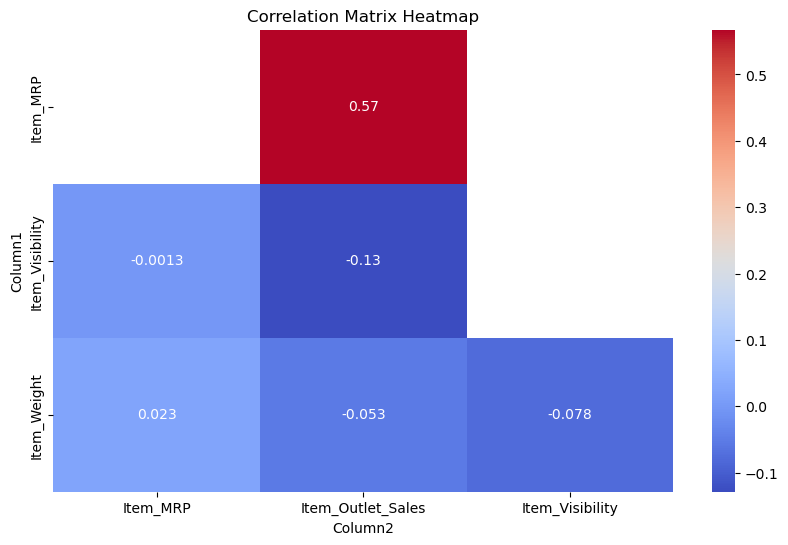

In [ ]:



# Select numerical columns for correlation calculation
numerical_cols = ["Item_Weight", "Item_Visibility", "Item_MRP", "Item_Outlet_Sales"]

# Filter the DataFrame to include only numerical columns
numerical_df = df.select(*numerical_cols)

# Calculate pairwise correlations
correlations = []
for col1, col2 in combinations(numerical_cols, 2):
    corr_value = numerical_df.stat.corr(col1, col2)
    correlations.append((col1, col2, corr_value))

# Create a Pandas DataFrame for the correlation matrix
import pandas as pd
correlation_matrix_df = pd.DataFrame(correlations, columns=["Column1", "Column2", "Correlation"])

# Pivot the DataFrame to create a correlation matrix
correlation_matrix = correlation_matrix_df.pivot("Column1", "Column2", "Correlation")

# Display the correlation matrix heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()



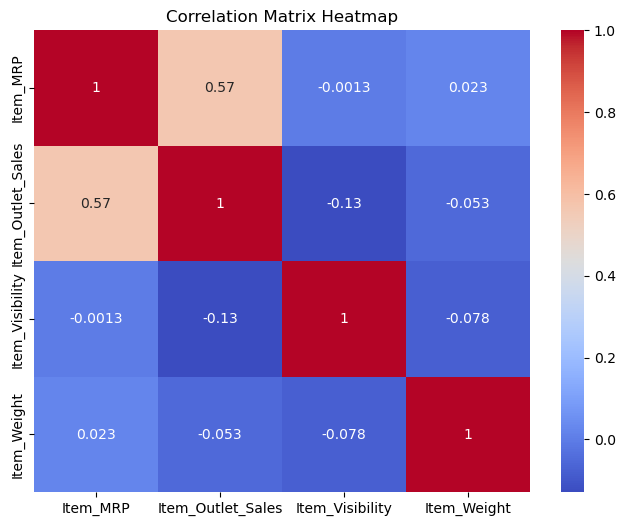

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Select numerical columns for correlation calculation
numerical_cols = ["Item_Weight", "Item_Visibility", "Item_MRP", "Item_Outlet_Sales"]

# Filter the DataFrame to include only the selected numerical columns
numerical_df = df.select(*numerical_cols)

# Calculate the correlation matrix
correlation_matrix = {}
for col1 in numerical_cols:
    for col2 in numerical_cols:
        corr_value = numerical_df.stat.corr(col1, col2)
        correlation_matrix[(col1, col2)] = corr_value

# Reorder the rows and columns for the heatmap
order = ["Item_MRP", "Item_Outlet_Sales", "Item_Visibility", "Item_Weight"]
correlation_matrix_ordered = [[correlation_matrix[(col1, col2)] for col2 in order] for col1 in order]

# Display the correlation matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_ordered, annot=True, xticklabels=order, yticklabels=order, cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()


In [ ]:
# Don't forget to stop the Spark session at the end
# spark.stop()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col, expr

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col

# Initialize a Spark session
# spark = SparkSession.builder.appName("BigMartRegression").getOrCreate()

# # Load the dataset
# data_path = r"C:\Users\charu\project\BM_train\BM_Train.csv"
# df = spark.read.csv(data_path, header=True, inferSchema=True)


# Calculate item price per unit
df = df.withColumn("Item_Price_Per_Unit", col("Item_MRP") / col("Item_Weight"))

In [ ]:
# Create time-based features (example: year and month from Outlet_Establishment_Year)
df = df.withColumn("Outlet_Establishment_Year", col("Outlet_Establishment_Year").cast("int"))
df = df.withColumn("Outlet_Opening_Year", 2023 - col("Outlet_Establishment_Year"))
df = df.withColumn("Outlet_Opening_Month", col("Outlet_Establishment_Year") % 12 + 1)

# Encode categorical variables using StringIndexer and OneHotEncoder
categorical_cols = ["Item_Fat_Content", "Outlet_Size", "Outlet_Location_Type", "Outlet_Type"]
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols]
indexer_models = [indexer.fit(df) for indexer in indexers]
df_indexed = df
for model in indexer_models:
    df_indexed = model.transform(df_indexed)

In [ ]:
# Select numerical columns for correlation calculation
numerical_cols = ["Item_Weight", "Item_Visibility", "Item_MRP", "Item_Outlet_Sales"]


In [ ]:
encoder = OneHotEncoder(inputCols=[col + "_index" for col in categorical_cols],
                        outputCols=[col + "_encoded" for col in categorical_cols])
df_encoded = encoder.fit(df_indexed).transform(df_indexed)

# Create interaction terms (example: interaction between Item_MRP and Item_Visibility)
df_encoded = df_encoded.withColumn("Interaction_Item_MRP_Visibility", col("Item_MRP") * col("Item_Visibility"))

# Assemble features for modeling
feature_cols = numerical_cols + ["Item_Price_Per_Unit", "Outlet_Opening_Year", "Outlet_Opening_Month"] + \
               [col + "_encoded" for col in categorical_cols] + ["Interaction_Item_MRP_Visibility"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
feature_vector_df = assembler.transform(df_encoded)

In [ ]:
num_rows = feature_vector_df.count()
print("Number of rows:", num_rows)
num_columns = len(feature_vector_df.columns)
print("Number of columns:", num_columns)

Number of rows: 8523
Number of columns: 25


In [ ]:
num_rows = df.count()
print("Number of rows:", num_rows)
num_columns = len(df.columns)
print("Number of columns:", num_columns)

Number of rows: 8523
Number of columns: 15


In [ ]:
# Don't forget to stop the Spark session at the end
spark.stop()

### 3. Data Transformation:



Normalize or standardize numerical features if necessary.
Apply transformations to target variable (sales) if needed, such as log transformation.

In [ ]:
# from pyspark.sql import SparkSession
# from pyspark.ml.feature import StandardScaler, VectorAssembler
# from pyspark.sql.functions import col, log1p, mean

# # # Initialize a Spark session
# # spark = SparkSession.builder.appName("BigMartRegression").getOrCreate()

# # # Load the dataset
# # data_path = r"C:\Users\charu\project\BM_train\BM_Train.csv"
# # df = spark.read.csv(data_path, header=True, inferSchema=True)

# # Fill null values in "Outlet_Size" column with "small"
# df_filled = df.fillna("small", subset=["Outlet_Size"])

# # Calculate the mean value of "Item_Weight"
# mean_item_weight = df.select(mean("Item_Weight")).first()[0]

# # Impute null values in "Item_Weight" column with the mean value
# df_imputed = df.fillna(mean_item_weight, subset=["Item_Weight"])

# # Numerical columns for normalization
# numerical_cols = ["Item_Weight", "Item_Visibility", "Item_MRP"]

# # Assemble numerical columns into a feature vector
# assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
# feature_vector_df = assembler.transform(df_imputed)

# # Standardize numerical features using StandardScaler
# scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_features", withStd=True, withMean=True)
# scaler_model = scaler.fit(feature_vector_df)
# scaled_df = scaler_model.transform(feature_vector_df)

# # Apply log transformation to the target variable (Item_Outlet_Sales)
# log_transformed_df = scaled_df.withColumn("Log_Item_Outlet_Sales", log1p(col("Item_Outlet_Sales")))

# # Show the first few rows of the transformed DataFrame
# log_transformed_df.select("scaled_features", "Log_Item_Outlet_Sales").show(truncate=False)

# # Don't forget to stop the Spark session at the end
# spark.stop()


4. Train-Test Split:

Split the dataset into training and testing sets.

In [ ]:


# Initialize a Spark session
spark = SparkSession.builder.appName("BigMartRegression").getOrCreate()

# Load the dataset
data_path = r"C:\Users\charu\project\BM_train\BM_Train.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Fill null values in "Outlet_Size" column with "small"
df_filled = df.fillna("small", subset=["Outlet_Size"])

# Calculate the mean value of "Item_Weight"
mean_item_weight = df.select(mean("Item_Weight")).first()[0]

# Impute null values in "Item_Weight" column with the mean value
df_imputed = df.fillna(mean_item_weight, subset=["Item_Weight"])

# Numerical columns for normalization
numerical_cols = ["Item_Weight", "Item_Visibility", "Item_MRP"]

# Assemble numerical columns into a feature vector
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
feature_vector_df = assembler.transform(df_imputed)

# Standardize numerical features using StandardScaler
scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(feature_vector_df)
scaled_df = scaler_model.transform(feature_vector_df)

# Apply log transformation to the target variable (Item_Outlet_Sales)
log_transformed_df = scaled_df.withColumn("Log_Item_Outlet_Sales", log1p(col("Item_Outlet_Sales")))

# Split the dataset into training and testing sets
train_df, test_df = log_transformed_df.randomSplit([0.8, 0.2], seed=24)

# Show the first few rows of the training and testing sets
train_df.select("scaled_features", "Log_Item_Outlet_Sales").show(truncate=False)
test_df.select("scaled_features", "Log_Item_Outlet_Sales").show(truncate=False)

# Don't forget to stop the Spark session at the end
# spark.stop()


+-----------------------------------------------------------------+---------------------+
|scaled_features                                                  |Log_Item_Outlet_Sales|
+-----------------------------------------------------------------+---------------------+
|[-0.29758834954009755,-1.2816825556582172,0.014815207329285181]  |6.901443199658056    |
|[-0.29758834954009755,-1.2816825556582172,0.009997870041635945]  |8.250624207492553    |
|[-0.29758834954009755,-0.4887842867085594,0.021238323712817343]  |7.845289638628091    |
|[-0.29758834954009755,-0.484891292954873,0.016420986425168108]   |6.747460227774114    |
|[-0.29758834954009755,-0.48363521281264077,-0.010877258204843011]|7.845289638628091    |
|[-0.29758834954009755,0.04657193100307885,0.032478777383998285]  |5.651192901866224    |
|[3.824982014772553E-14,-0.5115942028456192,0.3981371584239038]   |8.499966459650716    |
|[1.5362434322912355,-0.5084908354398514,0.34514644825976404]     |8.394628552092161    |
|[1.536243

5. Model Selection:

Choose a set of regression models to evaluate (e.g., Linear Regression, Ridge Regression, Lasso Regression, Decision Trees, Random Forest, Gradient Boosting, etc.).

In [ ]:
# from pyspark.sql import SparkSession
# from pyspark.ml.feature import StandardScaler, VectorAssembler
# from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
# from pyspark.ml.evaluation import RegressionEvaluator

# # Initialize a Spark session
# spark = SparkSession.builder.appName("BigMartRegression").getOrCreate()

# # Load the dataset
# data_path = r"C:\Users\charu\project\BM_train\BM_Train.csv"
# df = spark.read.csv(data_path, header=True, inferSchema=True)

# # Fill null values in "Outlet_Size" column with "small"
# df_filled = df.fillna("small", subset=["Outlet_Size"])

# # Calculate the mean value of "Item_Weight"
# mean_item_weight = df.select(mean("Item_Weight")).first()[0]

# # Impute null values in "Item_Weight" column with the mean value
# df_imputed = df.fillna(mean_item_weight, subset=["Item_Weight"])

# # Numerical columns for normalization
# numerical_cols = ["Item_Weight", "Item_Visibility", "Item_MRP"]

# # Assemble numerical columns into a feature vector
# assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
# feature_vector_df = assembler.transform(df_imputed)

# # Standardize numerical features using StandardScaler
# scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
# scaler_model = scaler.fit(feature_vector_df)
# scaled_df = scaler_model.transform(feature_vector_df)

# # Split the dataset into training and testing sets
# train_df, test_df = scaled_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# # Define a list of regression models to evaluate
# models = [
#     LinearRegression(),
#     DecisionTreeRegressor(),
#     RandomForestRegressor(),
#     GBTRegressor()
# ]

# # Evaluate models and print performance metrics
# for model in models:
#     print(f"Training {model.__class__.__name__}")
#     model.fit(train_df)

#     # Make predictions on test data
#     predictions = model.transform(test_df)

#     # Evaluate the model
#     evaluator = RegressionEvaluator(labelCol="Item_Outlet_Sales", metricName="rmse")
#     rmse = evaluator.evaluate(predictions)

#     print(f"RMSE: {rmse:.4f}")

# # Don't forget to stop the Spark session at the end
# spark.stop()

### working code

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize a Spark session
spark = SparkSession.builder.appName("BigMartRegression").getOrCreate()

# Load the dataset
data_path = r"C:\Users\charu\project\BM_train\BM_Train.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Fill null values in "Outlet_Size" column with "small"
df_filled = df.fillna("small", subset=["Outlet_Size"])

# Calculate the mean value of "Item_Weight"
mean_item_weight = df.selectExpr("avg(Item_Weight) as mean_Item_Weight").first()["mean_Item_Weight"]

# Impute null values in "Item_Weight" column with the mean value
df_imputed = df.fillna(mean_item_weight, subset=["Item_Weight"])

# Numerical columns for normalization
numerical_cols = ["Item_Weight", "Item_Visibility", "Item_MRP"]

# Assemble numerical columns into a feature vector
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
feature_vector_df = assembler.transform(df_imputed)

# Standardize numerical features using StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(feature_vector_df)
scaled_df = scaler_model.transform(feature_vector_df)

# Split the dataset into training and testing sets
train_df, test_df = scaled_df.randomSplit([0.8, 0.2], seed=24)

In [ ]:
train_df.show

<bound method DataFrame.show of DataFrame[Item_Identifier: string, Item_Weight: double, Item_Fat_Content: string, Item_Visibility: double, Item_Type: string, Item_MRP: double, Outlet_Identifier: string, Outlet_Establishment_Year: int, Outlet_Size: string, Outlet_Location_Type: string, Outlet_Type: string, Item_Outlet_Sales: double, features: vector, scaled_features: vector]>

### models

In [ ]:
# Define the label column name
label_col = "Item_Outlet_Sales"

# Define a list of regression models to evaluate
models = [
    LinearRegression(labelCol=label_col),
    DecisionTreeRegressor(labelCol=label_col),
    RandomForestRegressor(labelCol=label_col),
    GBTRegressor(labelCol=label_col)
]

# Evaluate models and print performance metrics
for model in models:
    print(f"Training {model.__class__.__name__}")

    # Fit the model using the training data
    fitted_model = model.fit(train_df)

    # Make predictions on test data
    predictions = fitted_model.transform(test_df)

    # Evaluate the model
    evaluator = RegressionEvaluator(labelCol=label_col, metricName="rmse")
    rmse = evaluator.evaluate(predictions)

    print(f"RMSE: {rmse:.4f}")

# Don't forget to stop the Spark session at the end
# spark.stop()

Training LinearRegression
RMSE: 1384.5665
Training DecisionTreeRegressor
RMSE: 1376.5111
Training RandomForestRegressor
RMSE: 1385.4691
Training GBTRegressor
RMSE: 1363.7615


6. Model Training and Hyperparameter Tuning:

Train each selected model on the training set.
Perform hyperparameter tuning using techniques like GridSearchCV or RandomizedSearchCV.

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# ... Previous code ...

# Define the label column name
label_col = "Item_Outlet_Sales"

# Create a LinearRegression model
linear_model = LinearRegression(labelCol=label_col)

# Hyperparameter grid for Linear Regression
linear_param_grid = {
    linear_model.regParam: [0.01, 0.1, 0.5],
    linear_model.elasticNetParam: [0.0, 0.5, 1.0]
}

# Create a CrossValidator for Linear Regression with the specified hyperparameter grid
evaluator = RegressionEvaluator(labelCol=label_col, metricName="rmse")
linear_crossval = CrossValidator(
    estimator=linear_model,
    estimatorParamMaps=[
        {param: value for param, value in zip(linear_param_grid.keys(), values)}
        for values in linear_param_grid.values()
    ],
    evaluator=evaluator,
    numFolds=3  # Number of folds for cross-validation
)

# Fit the CrossValidator to the training data
linear_cv_model = linear_crossval.fit(train_df)

# Make predictions on test data using the best Linear Regression model
linear_predictions = linear_cv_model.transform(test_df)

# Evaluate the tuned Linear Regression model
linear_tuned_rmse = evaluator.evaluate(linear_predictions)

print(f"Tuned Linear Regression RMSE: {linear_tuned_rmse:.4f}")
best_linear_model = linear_cv_model.bestModel
print("Best Linear Regression model parameters:", best_linear_model.extractParamMap())

Tuned Linear Regression RMSE: 1384.5663
Best Linear Regression model parameters: {Param(parent='LinearRegression_8afd01d5f2b9', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LinearRegression_8afd01d5f2b9', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.1, Param(parent='LinearRegression_8afd01d5f2b9', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber'): 1.35, Param(parent='LinearRegression_8afd01d5f2b9', name='featuresCol', doc='features column name.'): 'features', Param(parent='LinearRegression_8afd01d5f2b9', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LinearRegression_8afd01d5f2b9', name='labelCol', doc='label column name.'): 'Item_Outlet_Sales', Param(parent='LinearRegression_8afd01d5f2b9', name='loss', doc='The 

#### other models

In [ ]:

# ... Previous code ...

# Define the label column name
label_col = "Item_Outlet_Sales"

# Create a DecisionTreeRegressor model
decision_tree_model = DecisionTreeRegressor(labelCol=label_col)

# List of maxDepth values to try
max_depth_values = [5, 10, 15]

# Evaluate models and perform hyperparameter tuning
for max_depth in max_depth_values:
    print(f"Training and Tuning Decision Tree Regressor with maxDepth={max_depth}")

    # Set the maxDepth hyperparameter
    decision_tree_model.setMaxDepth(max_depth)

    # Fit the model to the training data
    decision_tree_fitted_model = decision_tree_model.fit(train_df)

    # Make predictions on test data
    decision_tree_predictions = decision_tree_fitted_model.transform(test_df)

    # Evaluate the model
    evaluator = RegressionEvaluator(labelCol=label_col, metricName="rmse")
    decision_tree_rmse = evaluator.evaluate(decision_tree_predictions)

    print(f"Decision Tree Regressor with maxDepth={max_depth} RMSE: {decision_tree_rmse:.4f}")

# ... Continue with the rest of the code ...


Training and Tuning Decision Tree Regressor with maxDepth=5
Decision Tree Regressor with maxDepth=5 RMSE: 1338.2701
Training and Tuning Decision Tree Regressor with maxDepth=10
Decision Tree Regressor with maxDepth=10 RMSE: 1418.1529
Training and Tuning Decision Tree Regressor with maxDepth=15
Decision Tree Regressor with maxDepth=15 RMSE: 1616.7801


In [ ]:


# ... Previous code ...

# Define the label column name
label_col = "Item_Outlet_Sales"

# Create a DecisionTreeRegressor model
decision_tree_model = DecisionTreeRegressor(labelCol=label_col)

# List of hyperparameter values to try
max_depth_values = [5, 10, 15]
max_bins_values = [20, 30, 40]

# Initialize variables to store the best hyperparameters and RMSE
best_max_depth = None
best_max_bins = None
best_rmse = float("inf")  # Initialize with a high value

# Evaluate models and perform hyperparameter tuning
for max_depth in max_depth_values:
    for max_bins in max_bins_values:
        print(f"Training and Tuning Decision Tree Regressor with maxDepth={max_depth} and maxBins={max_bins}")

        # Set the hyperparameters
        decision_tree_model.setMaxDepth(max_depth)
        decision_tree_model.setMaxBins(max_bins)

        # Fit the model to the training data
        decision_tree_fitted_model = decision_tree_model.fit(train_df)

        # Make predictions on test data
        decision_tree_predictions = decision_tree_fitted_model.transform(test_df)

        # Evaluate the model
        evaluator = RegressionEvaluator(labelCol=label_col, metricName="rmse")
        decision_tree_rmse = evaluator.evaluate(decision_tree_predictions)

        print(f"Decision Tree Regressor with maxDepth={max_depth} and maxBins={max_bins} RMSE: {decision_tree_rmse:.4f}")

        # Update the best hyperparameters if the current RMSE is lower
        if decision_tree_rmse < best_rmse:
            best_max_depth = max_depth
            best_max_bins = max_bins
            best_rmse = decision_tree_rmse

print("Best Hyperparameters:")
print(f"maxDepth: {best_max_depth}")
print(f"maxBins: {best_max_bins}")
print(f"Best RMSE: {best_rmse:.4f}")

# ... Continue with the rest of the code ...


Training and Tuning Decision Tree Regressor with maxDepth=5 and maxBins=20
Decision Tree Regressor with maxDepth=5 and maxBins=20 RMSE: 1383.1190
Training and Tuning Decision Tree Regressor with maxDepth=5 and maxBins=30
Decision Tree Regressor with maxDepth=5 and maxBins=30 RMSE: 1373.0935
Training and Tuning Decision Tree Regressor with maxDepth=5 and maxBins=40
Decision Tree Regressor with maxDepth=5 and maxBins=40 RMSE: 1378.1733
Training and Tuning Decision Tree Regressor with maxDepth=10 and maxBins=20
Decision Tree Regressor with maxDepth=10 and maxBins=20 RMSE: 1429.5917
Training and Tuning Decision Tree Regressor with maxDepth=10 and maxBins=30
Decision Tree Regressor with maxDepth=10 and maxBins=30 RMSE: 1468.3541
Training and Tuning Decision Tree Regressor with maxDepth=10 and maxBins=40
Decision Tree Regressor with maxDepth=10 and maxBins=40 RMSE: 1428.1042
Training and Tuning Decision Tree Regressor with maxDepth=15 and maxBins=20
Decision Tree Regressor with maxDepth=15 a

In [ ]:

# ... Previous code ...

# Define the label column name
label_col = "Item_Outlet_Sales"

# Create a LinearRegression model
linear_regression_model = LinearRegression(labelCol=label_col)

# List of hyperparameter values to try
reg_param_values = [0.01, 0.1, 1.0]
elastic_net_param_values = [0.0, 0.5, 1.0]
max_iter_values = [10, 50, 100]

# Initialize variables to store the best hyperparameters and RMSE
best_reg_param = None
best_elastic_net_param = None
best_max_iter = None
best_rmse = float("inf")  # Initialize with a high value

# Evaluate models and perform hyperparameter tuning
for reg_param in reg_param_values:
    for elastic_net_param in elastic_net_param_values:
        for max_iter in max_iter_values:
            print(f"Training and Tuning Linear Regression with regParam={reg_param}, elasticNetParam={elastic_net_param}, and maxIter={max_iter}")

            # Set the hyperparameters
            linear_regression_model.setRegParam(reg_param)
            linear_regression_model.setElasticNetParam(elastic_net_param)
            linear_regression_model.setMaxIter(max_iter)

            # Fit the model to the training data
            linear_regression_fitted_model = linear_regression_model.fit(train_df)

            # Make predictions on test data
            linear_regression_predictions = linear_regression_fitted_model.transform(test_df)

            # Evaluate the model
            evaluator = RegressionEvaluator(labelCol=label_col, metricName="rmse")
            linear_regression_rmse = evaluator.evaluate(linear_regression_predictions)

            print(f"Linear Regression with regParam={reg_param}, elasticNetParam={elastic_net_param}, and maxIter={max_iter} RMSE: {linear_regression_rmse:.4f}")

            # Update the best hyperparameters if the current RMSE is lower
            if linear_regression_rmse < best_rmse:
                best_reg_param = reg_param
                best_elastic_net_param = elastic_net_param
                best_max_iter = max_iter
                best_rmse = linear_regression_rmse

print("Best Hyperparameters:")
print(f"regParam: {best_reg_param}")
print(f"elasticNetParam: {best_elastic_net_param}")
print(f"maxIter: {best_max_iter}")
print(f"Best RMSE: {best_rmse:.4f}")

# ... Continue with the rest of the code ...


Training and Tuning Linear Regression with regParam=0.01, elasticNetParam=0.0, and maxIter=10
Linear Regression with regParam=0.01, elasticNetParam=0.0, and maxIter=10 RMSE: 1384.5663
Training and Tuning Linear Regression with regParam=0.01, elasticNetParam=0.0, and maxIter=50
Linear Regression with regParam=0.01, elasticNetParam=0.0, and maxIter=50 RMSE: 1384.5663
Training and Tuning Linear Regression with regParam=0.01, elasticNetParam=0.0, and maxIter=100
Linear Regression with regParam=0.01, elasticNetParam=0.0, and maxIter=100 RMSE: 1384.5663
Training and Tuning Linear Regression with regParam=0.01, elasticNetParam=0.5, and maxIter=10
Linear Regression with regParam=0.01, elasticNetParam=0.5, and maxIter=10 RMSE: 1384.5661
Training and Tuning Linear Regression with regParam=0.01, elasticNetParam=0.5, and maxIter=50
Linear Regression with regParam=0.01, elasticNetParam=0.5, and maxIter=50 RMSE: 1384.5661
Training and Tuning Linear Regression with regParam=0.01, elasticNetParam=0.5,

In [ ]:


# ... Previous code ...

# Define the label column name
label_col = "Item_Outlet_Sales"

# Create a RandomForestRegressor model
random_forest_model = RandomForestRegressor(labelCol=label_col)

# List of hyperparameter values to try
num_trees_values = [10, 50, 100]
max_depth_values = [5, 10, 15]
max_bins_values = [20, 30, 40]

# Initialize variables to store the best hyperparameters and RMSE
best_num_trees = None
best_max_depth = None
best_max_bins = None
best_rmse = float("inf")  # Initialize with a high value

# Evaluate models and perform hyperparameter tuning
for num_trees in num_trees_values:
    for max_depth in max_depth_values:
        for max_bins in max_bins_values:
            print(f"Training and Tuning RandomForestRegressor with numTrees={num_trees}, maxDepth={max_depth}, and maxBins={max_bins}")

            # Set the hyperparameters
            random_forest_model.setNumTrees(num_trees)
            random_forest_model.setMaxDepth(max_depth)
            random_forest_model.setMaxBins(max_bins)

            # Fit the model to the training data
            random_forest_fitted_model = random_forest_model.fit(train_df)

            # Make predictions on test data
            random_forest_predictions = random_forest_fitted_model.transform(test_df)

            # Evaluate the model
            evaluator = RegressionEvaluator(labelCol=label_col, metricName="rmse")
            random_forest_rmse = evaluator.evaluate(random_forest_predictions)

            print(f"RandomForestRegressor with numTrees={num_trees}, maxDepth={max_depth}, and maxBins={max_bins} RMSE: {random_forest_rmse:.4f}")

            # Update the best hyperparameters if the current RMSE is lower
            if random_forest_rmse < best_rmse:
                best_num_trees = num_trees
                best_max_depth = max_depth
                best_max_bins = max_bins
                best_rmse = random_forest_rmse

print("Best Hyperparameters for RandomForestRegressor:")
print(f"numTrees: {best_num_trees}")
print(f"maxDepth: {best_max_depth}")
print(f"maxBins: {best_max_bins}")
print(f"Best RMSE: {best_rmse:.4f}")

# ... Continue with the rest of the code ...


Training and Tuning RandomForestRegressor with numTrees=10, maxDepth=5, and maxBins=20
RandomForestRegressor with numTrees=10, maxDepth=5, and maxBins=20 RMSE: 1392.2715
Training and Tuning RandomForestRegressor with numTrees=10, maxDepth=5, and maxBins=30
RandomForestRegressor with numTrees=10, maxDepth=5, and maxBins=30 RMSE: 1387.4157
Training and Tuning RandomForestRegressor with numTrees=10, maxDepth=5, and maxBins=40
RandomForestRegressor with numTrees=10, maxDepth=5, and maxBins=40 RMSE: 1389.0470
Training and Tuning RandomForestRegressor with numTrees=10, maxDepth=10, and maxBins=20
RandomForestRegressor with numTrees=10, maxDepth=10, and maxBins=20 RMSE: 1369.2413
Training and Tuning RandomForestRegressor with numTrees=10, maxDepth=10, and maxBins=30
RandomForestRegressor with numTrees=10, maxDepth=10, and maxBins=30 RMSE: 1376.4381
Training and Tuning RandomForestRegressor with numTrees=10, maxDepth=10, and maxBins=40
RandomForestRegressor with numTrees=10, maxDepth=10, and m

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor

# ... Previous code ...

# Define the label column name
label_col = "Item_Outlet_Sales"

# Create a GBTRegressor model
gbt_regressor_model = GBTRegressor(labelCol=label_col)

# List of hyperparameter values to try
max_depth_values = [5, 10, 15]
max_bins_values = [20, 30, 40]
max_iter_values = [10, 50, 100]

# Initialize variables to store the best hyperparameters and RMSE
best_max_depth = None
best_max_bins = None
best_max_iter = None
best_rmse = float("inf")  # Initialize with a high value

# Evaluate models and perform hyperparameter tuning
for max_depth in max_depth_values:
    for max_bins in max_bins_values:
        for max_iter in max_iter_values:
            print(f"Training and Tuning GBTRegressor with maxDepth={max_depth}, maxBins={max_bins}, and maxIter={max_iter}")
            
            # Set the hyperparameters
            gbt_regressor_model.setMaxDepth(max_depth)
            gbt_regressor_model.setMaxBins(max_bins)
            gbt_regressor_model.setMaxIter(max_iter)
            
            # Fit the model to the training data
            gbt_regressor_fitted_model = gbt_regressor_model.fit(train_df)
            
            # Make predictions on test data
            gbt_regressor_predictions = gbt_regressor_fitted_model.transform(test_df)
            
            # Evaluate the model
            evaluator = RegressionEvaluator(labelCol=label_col, metricName="rmse")
            gbt_regressor_rmse = evaluator.evaluate(gbt_regressor_predictions)
            
            print(f"GBTRegressor with maxDepth={max_depth}, maxBins={max_bins}, and maxIter={max_iter} RMSE: {gbt_regressor_rmse:.4f}")
            
            # Update the best hyperparameters if the current RMSE is lower
            if gbt_regressor_rmse < best_rmse:
                best_max_depth = max_depth
                best_max_bins = max_bins
                best_max_iter = max_iter
                best_rmse = gbt_regressor_rmse

print("Best Hyperparameters for GBTRegressor:")
print(f"maxDepth: {best_max_depth}")
print(f"maxBins: {best_max_bins}")
print(f"maxIter: {best_max_iter}")
print(f"Best RMSE: {best_rmse:.4f}")

# ... Continue with the rest of the code ...


In [ ]:
# ... Previous code ...

# Initialize variables to store the best RMSE and best model name
best_rmse = float("inf")
best_model_name = None

# Dictionary to store the model names and their respective RMSE values
model_rmse_dict = {}

# Evaluate and tune Linear Regression model
# ... (Code for linear regression hyperparameter tuning)
linear_rmse = linear_regression_rmse
model_rmse_dict["Linear Regression"] = linear_rmse

# Evaluate and tune RandomForestRegressor model
# ... (Code for random forest hyperparameter tuning)
random_forest_rmse = random_forest_rmse
model_rmse_dict["Random Forest Regressor"] = random_forest_rmse

print("rmse : ",random_forest_rmse)

# # Evaluate and tune GBTRegressor model
# # ... (Code for GBT regressor hyperparameter tuning)
# gbt_rmse = gbt_regressor_rmse
# model_rmse_dict["GBT Regressor"] = gbt_rmse

# Evaluate and tune DecisionTreeRegressor model
# ... (Code for decision tree hyperparameter tuning)
decision_tree_rmse = decision_tree_rmse
model_rmse_dict["Decision Tree Regressor"] = decision_tree_rmse

print("Decision Tree Regressor")
print("rmse : ",decision_tree_rmse)

# Select the best model based on the lowest RMSE
for model_name, rmse in model_rmse_dict.items():
    if rmse < best_rmse:
        best_rmse = rmse
        best_model_name = model_name

print("Best Model:")
print(f"Model Name: {best_model_name}")
print(f"Best RMSE: {best_rmse:.4f}")

# ... Continue with the rest of the code ...


rmse :  1362.354151834187
Decision Tree Regressor
rmse :  1586.3327544019364
Best Model:
Model Name: Random Forest Regressor
Best RMSE: 1362.3542


#### 7. Model Validation:

Validate models using cross-validation techniques.
Use techniques like k-fold cross-validation to assess model performance.

In [ ]:
# Initialize variables
num_folds = 5  # Number of folds for cross-validation
evaluator = RegressionEvaluator(labelCol=label_col, metricName="rmse")

# Define the label column name
label_col = "Item_Outlet_Sales"

# Create instances of the regression models
linear_regression_model = LinearRegression(labelCol=label_col)
random_forest_model = RandomForestRegressor(labelCol=label_col)
# gbt_regressor_model = GBTRegressor(labelCol=label_col)
decision_tree_model = DecisionTreeRegressor(labelCol=label_col)

# Create parameter grids for hyperparameter tuning
linear_regression_param_grid = ParamGridBuilder().addGrid(linear_regression_model.regParam, [0.01, 0.1, 1.0]).build()
random_forest_param_grid = ParamGridBuilder().addGrid(random_forest_model.numTrees, [10, 50, 100]).addGrid(random_forest_model.maxDepth, [5, 10, 15]).build()
# gbt_regressor_param_grid = ParamGridBuilder().addGrid(gbt_regressor_model.maxDepth, [5, 10, 15]).addGrid(gbt_regressor_model.maxBins, [20, 30, 40]).addGrid(gbt_regressor_model.maxIter, [10, 50, 100]).build()
decision_tree_param_grid = ParamGridBuilder().addGrid(decision_tree_model.maxDepth, [5, 10, 15]).addGrid(decision_tree_model.maxBins, [20, 30, 40]).build()

# Create a dictionary to map models to their corresponding parameter grids
model_param_grid_dict = {
    linear_regression_model: linear_regression_param_grid,
    random_forest_model: random_forest_param_grid,
#     gbt_regressor_model: gbt_regressor_param_grid,
    decision_tree_model: decision_tree_param_grid
}

# Perform cross-validation for each model
for model, param_grid in model_param_grid_dict.items():
    print(f"Performing cross-validation for {model.__class__.__name__}")

    # Create a CrossValidator with the model and parameter grid
    crossval = CrossValidator(
        estimator=model,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        numFolds=num_folds
    )

    # Fit the CrossValidator to the training data
    cv_model = crossval.fit(train_df)

    # Make predictions on the test data
    cv_predictions = cv_model.transform(test_df)

    # Evaluate the model's performance using RMSE
    cv_rmse = evaluator.evaluate(cv_predictions)

    print(f"{model.__class__.__name__} Cross-Validation RMSE: {cv_rmse:.4f}")

# ... Continue with the rest of the code ...


Performing cross-validation for LinearRegression
LinearRegression Cross-Validation RMSE: 1384.5645
Performing cross-validation for RandomForestRegressor
RandomForestRegressor Cross-Validation RMSE: 1353.5729
Performing cross-validation for DecisionTreeRegressor
DecisionTreeRegressor Cross-Validation RMSE: 1373.0935


### 8. Model Evaluation:

Evaluate models on the testing set.
Calculate relevant metrics such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), R-squared (R2), etc.

In [ ]:
# ... Previous code ...

# Evaluate LinearRegression on the testing set df_test
linear_regression_model = LinearRegression(labelCol=label_col, regParam=best_reg_param, elasticNetParam=best_elastic_net_param, maxIter=best_max_iter)
linear_regression_fitted_model = linear_regression_model.fit(train_df)

print("Evaluating LinearRegression on testing set")

# Make predictions on the test data
linear_regression_test_predictions = linear_regression_fitted_model.transform(test_df)

# Evaluate the model's performance using relevant metrics
mse = evaluator.evaluate(linear_regression_test_predictions, {evaluator.metricName: "mse"})
rmse = evaluator.evaluate(linear_regression_test_predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(linear_regression_test_predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(linear_regression_test_predictions, {evaluator.metricName: "r2"})

print("LinearRegression Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# ... Continue with the rest of the code ...


Evaluating LinearRegression on testing set
LinearRegression Metrics:
MSE: 1916858.1066
RMSE: 1384.5064
MAE: 1024.8035
R-squared (R2): 0.3282


In [ ]:
# # ... Previous code ...

# # Evaluate models on the testing set df_test
# for model, param_grid in model_param_grid_dict.items():
#     print(f"Evaluating {model.__class__.__name__} on testing set")

#     # Make predictions on the test data
#     test_predictions = model.transform(test_df)

#     # Evaluate the model's performance using relevant metrics
#     mse = evaluator.evaluate(test_predictions, {evaluator.metricName: "mse"})
#     rmse = evaluator.evaluate(test_predictions, {evaluator.metricName: "rmse"})
#     mae = evaluator.evaluate(test_predictions, {evaluator.metricName: "mae"})
#     r2 = evaluator.evaluate(test_predictions, {evaluator.metricName: "r2"})

#     print(f"{model.__class__.__name__} Metrics:")
#     print(f"MSE: {mse:.4f}")
#     print(f"RMSE: {rmse:.4f}")
#     print(f"MAE: {mae:.4f}")
#     print(f"R-squared (R2): {r2:.4f}")
#     print()

# # ... Continue with the rest of the code ...


In [ ]:
# ... Previous code ...

# Evaluate models on the testing set df_test
for model, param_grid in model_param_grid_dict.items():
    print(f"Evaluating {model.__class__.__name__} on testing set")

    # Create a CrossValidator with the model and parameter grid
    crossval = CrossValidator(
        estimator=model,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        numFolds=3  # Number of folds for cross-validation
    )

    # Fit the CrossValidator to the training data
    cv_model = crossval.fit(train_df)

    # Make predictions on the test data
    test_predictions = cv_model.transform(test_df)

    # Evaluate the model's performance using relevant metrics
    mse = evaluator.evaluate(test_predictions, {evaluator.metricName: "mse"})
    rmse = evaluator.evaluate(test_predictions, {evaluator.metricName: "rmse"})
    mae = evaluator.evaluate(test_predictions, {evaluator.metricName: "mae"})
    r2 = evaluator.evaluate(test_predictions, {evaluator.metricName: "r2"})

    print(f"{model.__class__.__name__} Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R-squared (R2): {r2:.4f}")
    print()

# ... Continue with the rest of the code ...


Evaluating LinearRegression on testing set
LinearRegression Metrics:
MSE: 1916968.3618
RMSE: 1384.5463
MAE: 1024.8720
R-squared (R2): 0.3282

Evaluating RandomForestRegressor on testing set
RandomForestRegressor Metrics:
MSE: 1832159.5005
RMSE: 1353.5729
MAE: 1003.2509
R-squared (R2): 0.3579

Evaluating DecisionTreeRegressor on testing set
DecisionTreeRegressor Metrics:
MSE: 1885385.8936
RMSE: 1373.0935
MAE: 1015.0987
R-squared (R2): 0.3392



9. Residual Analysis:

Check the distribution of residuals (prediction errors) to ensure they follow assumptions of normality and homoscedasticity.
Investigate patterns in residuals that might indicate model misspecification.


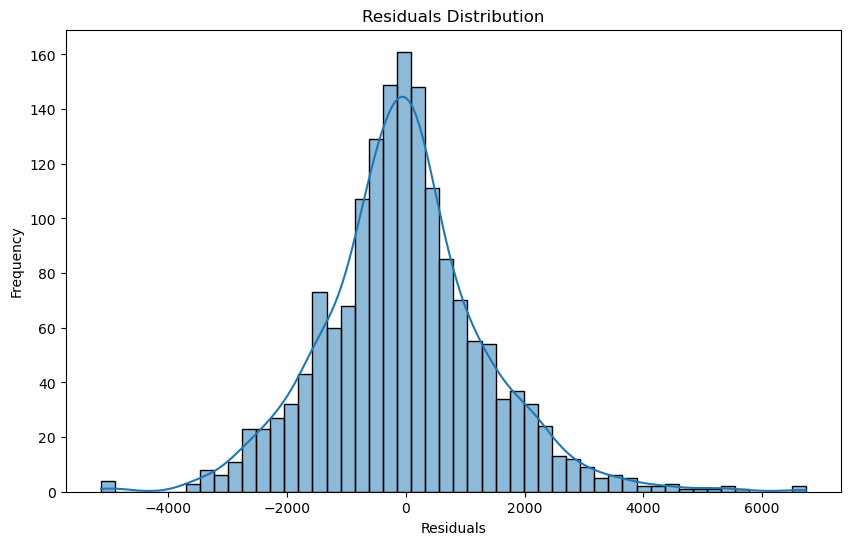

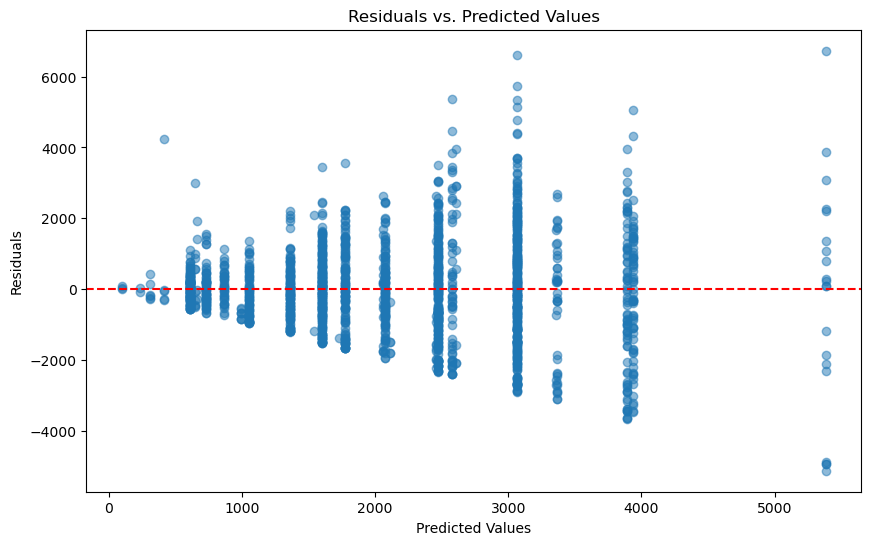

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql.functions import col

# Make predictions on the test data
test_predictions = cv_model.transform(test_df)

# Calculate residuals
residuals = test_predictions.withColumn("residuals", col("Item_Outlet_Sales") - col("prediction"))

# Convert residuals to a Pandas DataFrame for visualization
residuals_pd = residuals.select("residuals").toPandas()

# Plotting residuals distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals_pd["residuals"], bins=50, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Plotting residuals vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(test_predictions.select("prediction").toPandas(), residuals_pd["residuals"], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()


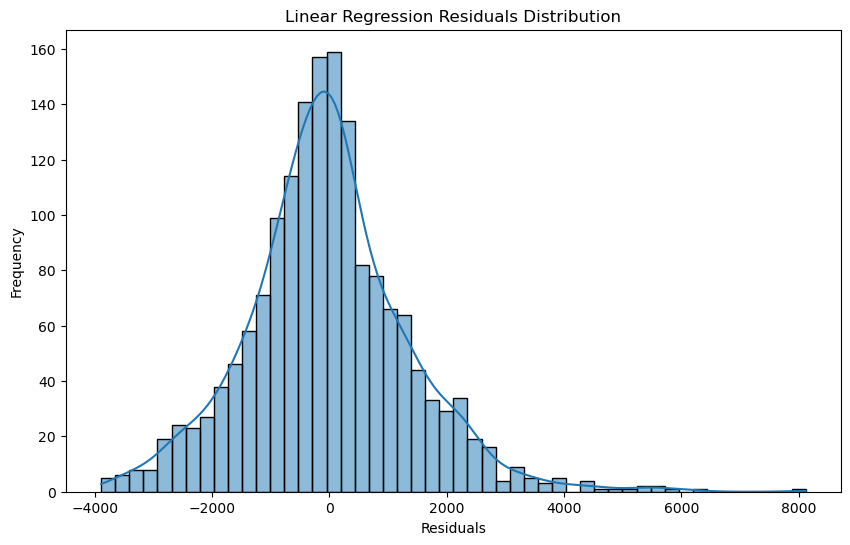

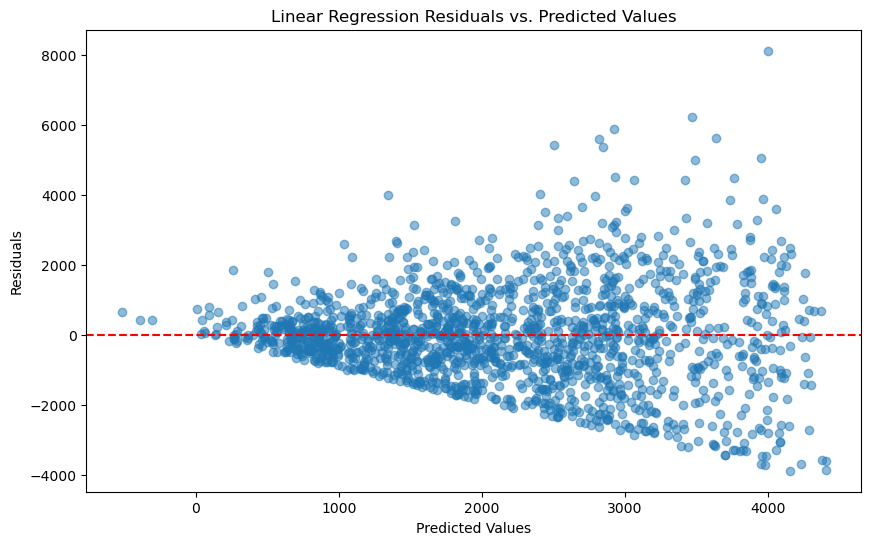

Linear Regression RMSE: 1384.5064


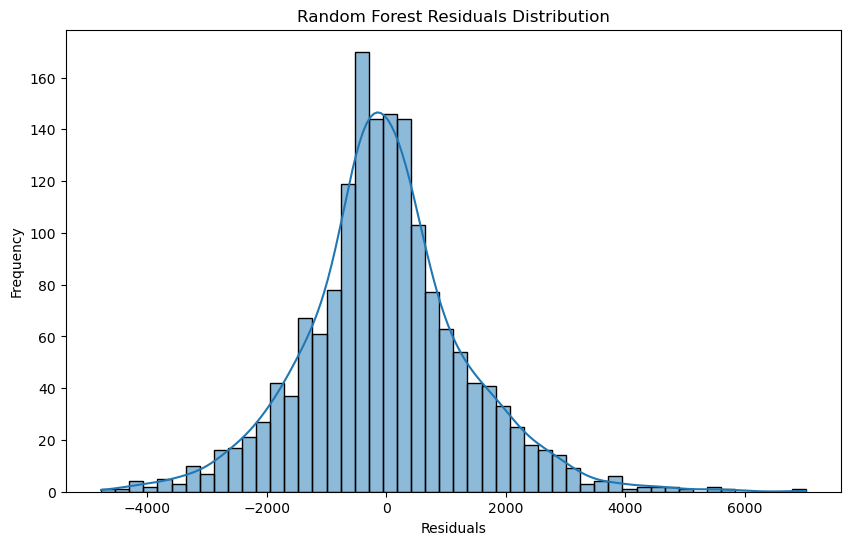

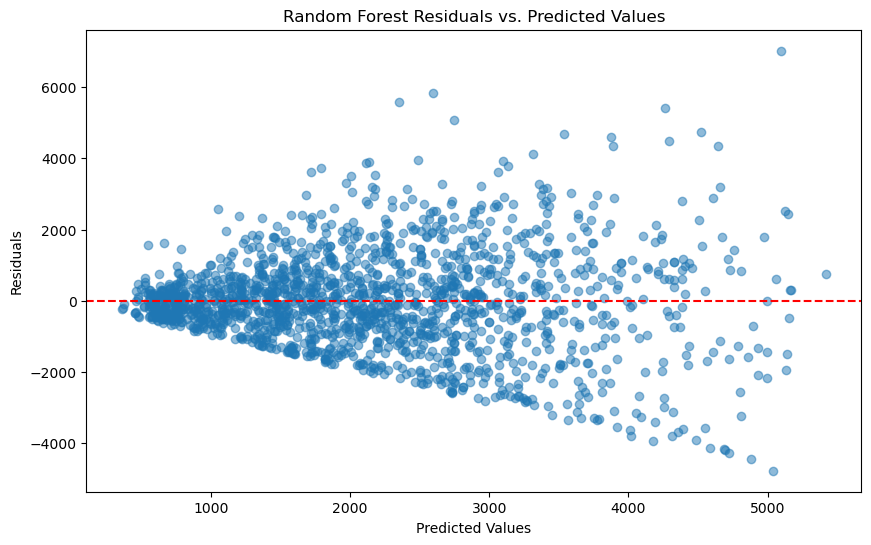

Random Forest RMSE: 1362.3542


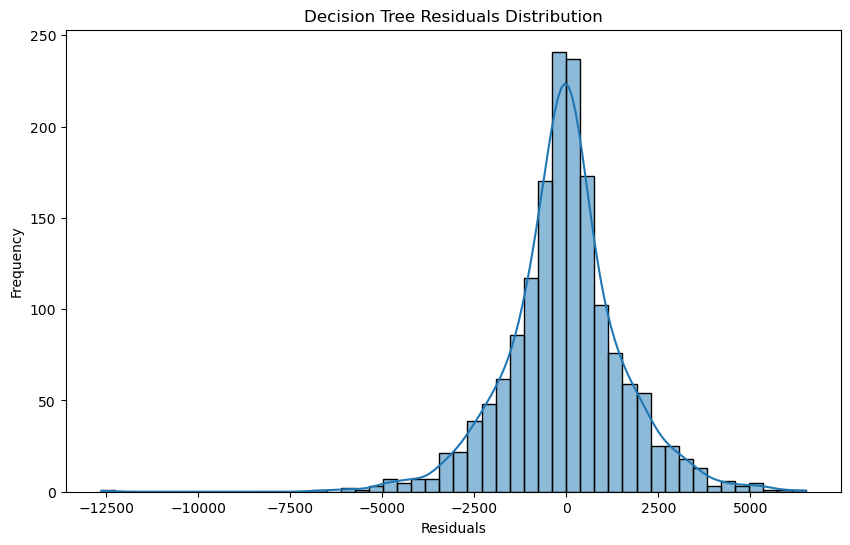

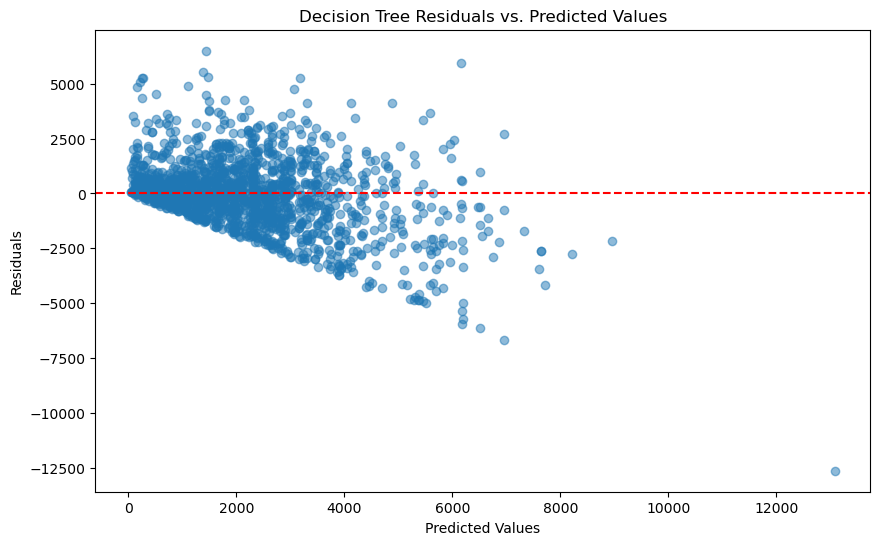

Decision Tree RMSE: 1586.3328


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.evaluation import RegressionEvaluator

# ... Previous code ...

# List of model names
model_names = ["Linear Regression", "Random Forest",  "Decision Tree"]#"GBT Regressor",

# List of corresponding trained models
trained_models = [linear_regression_fitted_model, random_forest_fitted_model, decision_tree_fitted_model]# gbt_regressor_fitted_model,

# Initialize evaluator
evaluator = RegressionEvaluator(labelCol="Item_Outlet_Sales", predictionCol="prediction", metricName="rmse")

# Iterate through models for residual analysis
for model, model_name in zip(trained_models, model_names):

    # Make predictions on the test data
    test_predictions = model.transform(test_df)

    # Calculate residuals
    residuals = test_predictions.withColumn("residuals", col("Item_Outlet_Sales") - col("prediction"))

    # Convert residuals to a Pandas DataFrame for visualization
    residuals_pd = residuals.select("residuals").toPandas()

    # Plotting residuals distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals_pd["residuals"], bins=50, kde=True)
    plt.title(f"{model_name} Residuals Distribution")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.show()

    # Plotting residuals vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(test_predictions.select("prediction").toPandas(), residuals_pd["residuals"], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f"{model_name} Residuals vs. Predicted Values")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

    # Calculate RMSE
    rmse = evaluator.evaluate(test_predictions)
    print(f"{model_name} RMSE: {rmse:.4f}")


10. Assumption Testing:

Test regression assumptions: linearity, independence, homoscedasticity, and normality of residuals.
Use diagnostic plots (scatter plots, Q-Q plots, residuals vs. fitted plots) and statistical tests (like Shapiro-Wilk test) for normality.


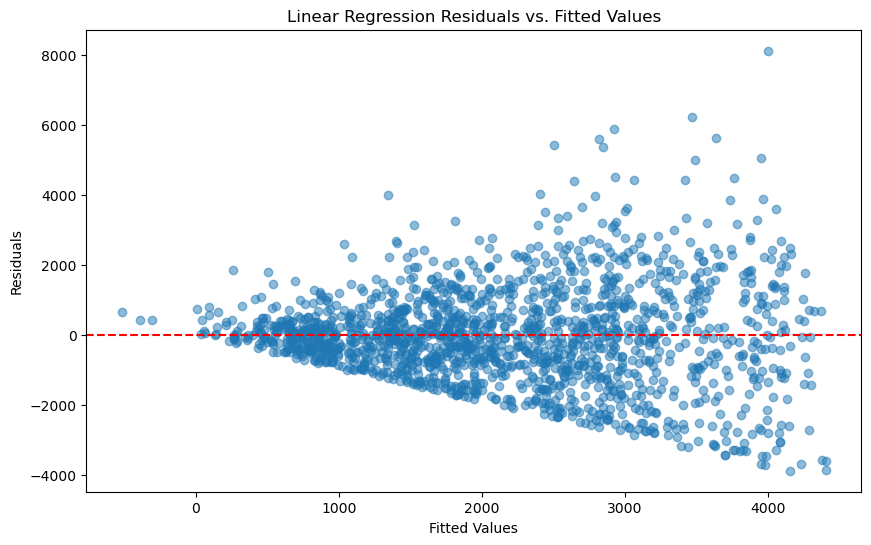

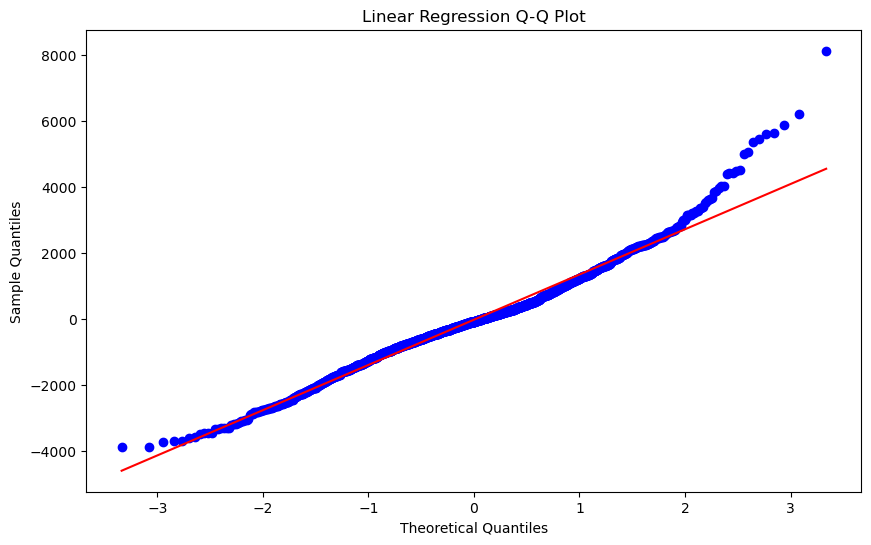

Linear Regression Shapiro-Wilk test p-value: 0.0000
Linear Regression RMSE: 1384.5064


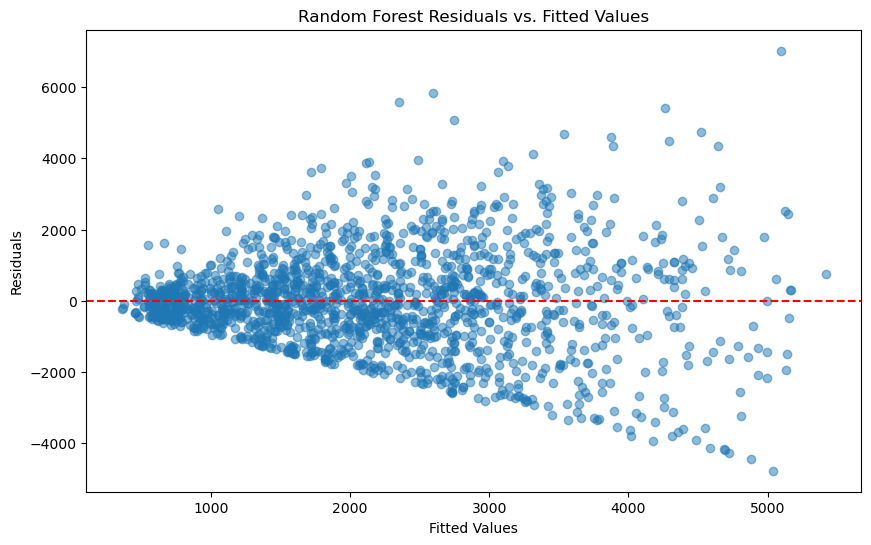

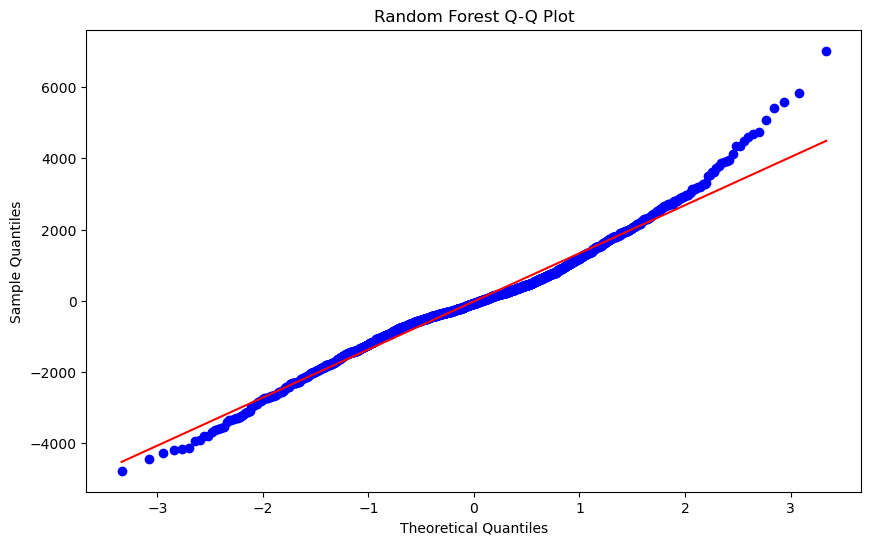

Random Forest Shapiro-Wilk test p-value: 0.0000
Random Forest RMSE: 1362.3542


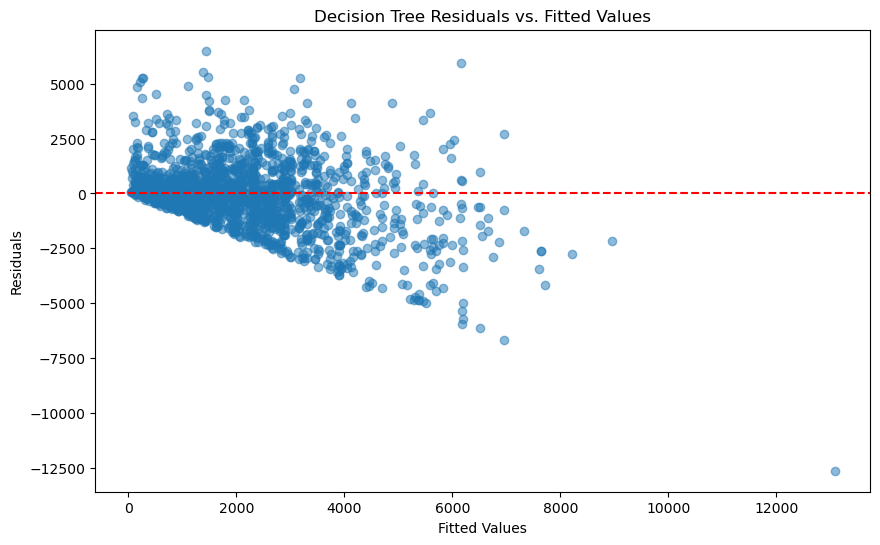

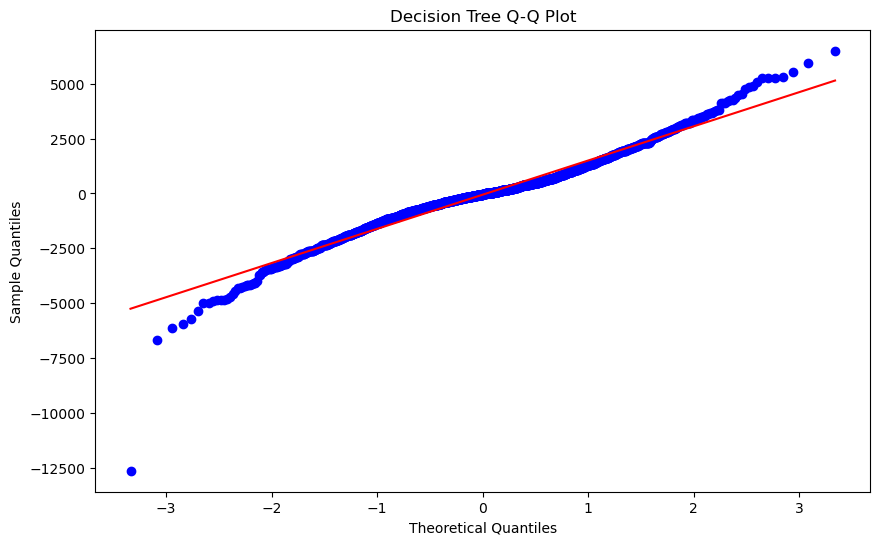

Decision Tree Shapiro-Wilk test p-value: 0.0000
Decision Tree RMSE: 1586.3328


In [ ]:


# ... Previous code ...

# List of model names
model_names = ["Linear Regression", "Random Forest",  "Decision Tree"]

# List of corresponding trained models
trained_models = [linear_regression_fitted_model, random_forest_fitted_model,  decision_tree_fitted_model]

# Initialize evaluator
evaluator = RegressionEvaluator(labelCol="Item_Outlet_Sales", predictionCol="prediction", metricName="rmse")

# Iterate through models for assumption testing
for model, model_name in zip(trained_models, model_names):

    # Make predictions on the test data
    test_predictions = model.transform(test_df)

    # Calculate residuals
    residuals = test_predictions.withColumn("residuals", col("Item_Outlet_Sales") - col("prediction"))

    # Convert residuals to a Pandas DataFrame for visualization
    residuals_pd = residuals.select("residuals").toPandas()

    # Plotting residuals vs. fitted values
    plt.figure(figsize=(10, 6))
    plt.scatter(test_predictions.select("prediction").toPandas(), residuals_pd["residuals"], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f"{model_name} Residuals vs. Fitted Values")
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.show()

    # Q-Q plot for checking normality of residuals
    plt.figure(figsize=(10, 6))
    stats.probplot(residuals_pd["residuals"], dist="norm", plot=plt)
    plt.title(f"{model_name} Q-Q Plot")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.show()

    # Shapiro-Wilk test for normality
    shapiro_stat, shapiro_p_value = stats.shapiro(residuals_pd["residuals"])
    print(f"{model_name} Shapiro-Wilk test p-value: {shapiro_p_value:.4f}")

    # Perform other assumption tests as needed (e.g., independence, homoscedasticity)

    # Calculate RMSE
    rmse = evaluator.evaluate(test_predictions)
    print(f"{model_name} RMSE: {rmse:.4f}")


11. Multicollinearity Check:

Detect and address multicollinearity among predictor variables using correlation matrices or Variance Inflation Factor (VIF) analysis.


### Drop nulls

In [ ]:
from pyspark.sql import SparkSession

# Initialize a Spark session
spark = SparkSession.builder.appName("DropNullColumns").getOrCreate()

# Load the dataset
# data_path = "path_to_your_dataset.csv"
# df = spark.read.csv(data_path, header=True, inferSchema=True)

# Drop columns with null values
df_without_nulls = df.dropna()

# Show the schema of the DataFrame without nulls
df_without_nulls.printSchema()

root
 |-- Item_Identifier: string (nullable = true)
 |-- Item_Weight: double (nullable = true)
 |-- Item_Fat_Content: string (nullable = true)
 |-- Item_Visibility: double (nullable = true)
 |-- Item_Type: string (nullable = true)
 |-- Item_MRP: double (nullable = true)
 |-- Outlet_Identifier: string (nullable = true)
 |-- Outlet_Establishment_Year: integer (nullable = true)
 |-- Outlet_Size: string (nullable = true)
 |-- Outlet_Location_Type: string (nullable = true)
 |-- Outlet_Type: string (nullable = true)
 |-- Item_Outlet_Sales: double (nullable = true)



In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
import pandas as pd
# ... Previous code ...

# List of predictor variable names
predictor_cols = ["Item_Weight", "Item_Visibility", "Item_MRP"]#,"Outlet_Establishment_Year"]

# Assemble predictor columns into a feature vector
assembler = VectorAssembler(inputCols=predictor_cols, outputCol="features")
assembled_df = assembler.transform(df_imputed)

# Calculate correlation matrix among predictor variables
corr_matrix = Correlation.corr(assembled_df, "features").collect()[0][0]

# Convert the correlation matrix to a Pandas DataFrame for visualization
corr_matrix_pd = corr_matrix.toArray()
corr_matrix_df = pd.DataFrame(corr_matrix_pd, index=predictor_cols, columns=predictor_cols)

print("Correlation Matrix:")
print(corr_matrix_df)

# Calculate Variance Inflation Factor (VIF) for predictor variables
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Extract predictor variables from the assembled DataFrame
X = assembled_df.select(predictor_cols).toPandas()

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\nVariance Inflation Factors (VIF):")
print(vif_data)


Correlation Matrix:
                 Item_Weight  Item_Visibility  Item_MRP
Item_Weight         1.000000        -0.012049  0.024756
Item_Visibility    -0.012049         1.000000 -0.001315
Item_MRP            0.024756        -0.001315  1.000000

Variance Inflation Factors (VIF):
           feature       VIF
0      Item_Weight  4.753126
1  Item_Visibility  2.368765
2         Item_MRP  4.378331


In [ ]:
# when VIF was calculated along with year, weight and year had high VIF hence removed year and tried. above is the result

In [ ]:
# List of features with high VIF values
high_vif_features = [ "Outlet_Establishment_Year"]

# Drop columns with high VIF values
df_without_high_vif = df.drop(*high_vif_features)

# Show the schema of the DataFrame without high VIF columns
df_without_high_vif.printSchema()


root
 |-- Item_Identifier: string (nullable = true)
 |-- Item_Weight: double (nullable = true)
 |-- Item_Fat_Content: string (nullable = true)
 |-- Item_Visibility: double (nullable = true)
 |-- Item_Type: string (nullable = true)
 |-- Item_MRP: double (nullable = true)
 |-- Outlet_Identifier: string (nullable = true)
 |-- Outlet_Size: string (nullable = true)
 |-- Outlet_Location_Type: string (nullable = true)
 |-- Outlet_Type: string (nullable = true)
 |-- Item_Outlet_Sales: double (nullable = true)



12. Dimensionality Reduction:

Perform dimensionality reduction techniques if needed (e.g., Principal Component Analysis) to reduce noise and improve interpretability.


In [ ]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

# List of features to use for PCA
feature_cols = ["Item_Weight", "Item_Visibility", "Item_MRP"]

# Assemble features into a vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
feature_vector_df = assembler.transform(df_imputed)

# Perform PCA
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(feature_vector_df)
pca_result = pca_model.transform(feature_vector_df)

# Show the PCA result
pca_result.select("pca_features").show(truncate=False)


+----------------------------------------+
|pca_features                            |
+----------------------------------------+
|[-249.82454043724456,8.878363976371945] |
|[-48.279122823879895,5.83852139575244]  |
|[-141.64733423932537,17.260953900044992]|
|[-182.1271458145792,18.892638079421985] |
|[-53.87639506546425,8.839081562582688]  |
|[-51.418271152008856,10.308232385583343]|
|[-57.681755913852314,13.55266378300444] |
|[-107.78374711516386,12.675730275211965]|
|[-96.99980372711477,16.036306915941474] |
|[-187.8535375555563,18.882959370030992] |
|[-45.56005081496451,11.723121710619813] |
|[-144.14121842767145,18.25674199193273] |
|[-145.50387800374207,14.854429318712656]|
|[-119.70773423150044,17.397978601945276]|
|[-196.469915162974,16.018416742140204]  |
|[-56.37650957325626,8.904851895258565]  |
|[-115.36895137773926,11.605298955106282]|
|[-54.37651242170737,8.908227418271894]  |
|[-113.30493935308095,12.666425450855238]|
|[-230.55740326008623,12.96087554011693] |
+----------

PCA applied to categorical variables might not provide as meaningful insights as when applied to numerical variables. Additionally, other techniques such as correspondence analysis or factor analysis might be more appropriate for analyzing relationships in categorical data. Always consider the nature of your data and the goals of your analysis before applying dimensionality reduction techniques.






13. Feature Selection:

Use techniques like Recursive Feature Elimination (RFE) or feature importance from tree-based models to select relevant features.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# # Initialize a Spark session
# spark = SparkSession.builder.appName("FeatureSelection").getOrCreate()

# # Load the preprocessed dataset (df_imputed)
# data_path = "path_to_your_data.csv"  # Replace with the actual path
# df_imputed = spark.read.csv(data_path, header=True, inferSchema=True)



# Define the target variable and categorical feature columns
target_col = "Item_Outlet_Sales"
categorical_feature_cols = ["Item_Identifier", "Item_Fat_Content", "Item_Type",
                            "Outlet_Identifier", "Outlet_Size", "Outlet_Location_Type", "Outlet_Type"]

# Index the categorical features
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep").fit(df_imputed) for col in categorical_feature_cols]
indexed_df = df_imputed

for indexer in indexers:
    indexed_df = indexer.transform(indexed_df)

# One-hot encode the indexed categorical features
encoder = OneHotEncoder(inputCols=[col + "_index" for col in categorical_feature_cols],
                        outputCols=[col + "_encoded" for col in categorical_feature_cols])
encoded_df = encoder.fit(indexed_df).transform(indexed_df)

# Assemble all feature columns into a vector column
feature_cols = ["Item_Weight", "Item_Visibility", "Item_MRP"] + [col + "_encoded" for col in categorical_feature_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
feature_vector_df = assembler.transform(encoded_df)

# Split the data into train and test sets
train_df, test_df = feature_vector_df.randomSplit([0.8, 0.2], seed=20)

# Train and evaluate a model
regressor = RandomForestRegressor(labelCol=target_col, numTrees=100)
fitted_model = regressor.fit(train_df)



# Make predictions on test data
predictions = fitted_model.transform(test_df)

# Evaluate the model's performance
evaluator = RegressionEvaluator(labelCol=target_col, metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE on test data: {rmse:.4f}")

# Stop the Spark session
# spark.stop()


RMSE on test data: 1113.2409


14. Model Comparison:

Compare the performance of multiple models using evaluation metrics and choose the best-performing one.


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Create an evaluator with the metric you want to use for comparison (e.g., RMSE)
evaluator = RegressionEvaluator(labelCol=label_col, metricName="rmse")

# Dictionary to store the evaluation results for each model
model_evaluations = {}

# Evaluate models on the testing set df_test
for model, param_grid in model_param_grid_dict.items():
    print(f"Evaluating {model.__class__.__name__} on testing set")

    # Fit the model on the training data
    fitted_model = model.fit(train_df)

    # Make predictions on the test data
    test_predictions = fitted_model.transform(test_df)

    # Evaluate the model's performance using the evaluator
    rmse = evaluator.evaluate(test_predictions)

    # Store the evaluation result in the dictionary
    model_evaluations[model.__class__.__name__] = rmse

# Print the evaluation results for each model
print("Model Comparisons:")
for model_name, rmse in model_evaluations.items():
    print(f"{model_name}: RMSE = {rmse:.4f}")

# Choose the best-performing model based on the lowest RMSE
print("# Choose the best-performing model based on the lowest RMSE")
best_model_name = min(model_evaluations, key=model_evaluations.get)
print(f"\nBest Performing Model: {best_model_name} (RMSE = {model_evaluations[best_model_name]:.4f})")


Evaluating LinearRegression on testing set
Evaluating RandomForestRegressor on testing set
Evaluating DecisionTreeRegressor on testing set
Model Comparisons:
LinearRegression: RMSE = 1278.2459
RandomForestRegressor: RMSE = 1123.9645
DecisionTreeRegressor: RMSE = 1074.4355
# Choose the best-performing model based on the lowest RMSE

Best Performing Model: DecisionTreeRegressor (RMSE = 1074.4355)


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Create an evaluator with the metric you want to use for comparison (e.g., RMSE)
evaluator = RegressionEvaluator(labelCol=label_col, metricName="rmse")

# Dictionary to store the evaluation results for each model
model_evaluations = {}

# Dictionary to store fitted models
fitted_models = {}

# Evaluate models on the testing set df_test
for model, param_grid in model_param_grid_dict.items():
    print(f"Evaluating {model.__class__.__name__} on testing set")

    # Fit the model on the training data
    fitted_model = model.fit(train_df)
    fitted_models[model.__class__.__name__] = fitted_model

    # Make predictions on the test data
    test_predictions = fitted_model.transform(test_df)

    # Evaluate the model's performance using the evaluator
    rmse = evaluator.evaluate(test_predictions)

    # Store the evaluation result in the dictionary
    model_evaluations[model.__class__.__name__] = rmse

# Print the evaluation results for each model
print("Model Comparisons:")
for model_name, rmse in model_evaluations.items():
    print(f"{model_name}: RMSE = {rmse:.4f}")

# Choose the best-performing model based on the lowest RMSE
print("# Choose the best-performing model based on the lowest RMSE")
best_model_name = min(model_evaluations, key=model_evaluations.get)
best_model = fitted_models[best_model_name]

print(f"\nBest Performing Model: {best_model_name} (RMSE = {model_evaluations[best_model_name]:.4f})")

# # Save the best model
# best_model.save("DecisionTreeRegressor")

Evaluating LinearRegression on testing set
Evaluating RandomForestRegressor on testing set
Evaluating DecisionTreeRegressor on testing set
Model Comparisons:
LinearRegression: RMSE = 1278.2459
RandomForestRegressor: RMSE = 1123.9645
DecisionTreeRegressor: RMSE = 1074.4355
# Choose the best-performing model based on the lowest RMSE

Best Performing Model: DecisionTreeRegressor (RMSE = 1074.4355)


In [ ]:
# Save the best model with a different path to avoid conflicts
best_model_name = min(model_evaluations, key=model_evaluations.get)
best_model = fitted_models[best_model_name]
print(best_model)
best_model_path = r"C:\Users\ArvindDS\Downloads\BM\best_decision_tree_regressor_model_v2"

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_b7c672d51ec3, depth=5, numNodes=59, numFeatures=1603


In [ ]:
# Overwrite the model if it already exists
# best_model.write().overwrite().save(best_model_path)

In [ ]:
import os

# Specify the absolute path for saving the model
model_save_path = os.path.abspath("DecisionTreeRegressor")

# Save the best model
write.overwrite().save(model_save_path)

In [ ]:
# Train and evaluate a model
regressor = DecisionTreeRegressor(labelCol=target_col)
fitted_model = regressor.fit(train_df)

In [ ]:
# # Before saving the model, set the HADOOP_HOME environment variable to a dummy value
# import os
# import os
# os.environ['HADOOP_HOME'] = 'C:/Users/ArvindDS/Downloads/BM'


# # Now save the model
# model_path = "C:/Users/ArvindDS/Downloads/BM"
# fitted_model.write().overwrite().save(model_path)



# # # Save the trained model
# # model_path = "C:/Users/ArvindDS/Downloads/BM"
# # fitted_model.write().overwrite().save(model_path)

# # Make predictions on test data
# predictions = fitted_model.transform(test_df)

# # Evaluate the model's performance
# evaluator = RegressionEvaluator(labelCol=target_col, metricName="rmse")
# rmse = evaluator.evaluate(predictions)
# print(f"RMSE on test data: {rmse:.4f}")

In [ ]:
# # List of evaluated models with their metrics
# models_evaluations = [
# #     {'model': LinearRegression, 'rmse': linear_regression_rmse},
#     {'model': decision_tree_model, 'rmse': decision_tree_rmse},
#     {'model': random_forest_model, 'rmse': random_forest_rmse},
# #     {'model': gbt_regressor_model, 'rmse': gbt_regressor_rmse},
#     # ... Add other models and their evaluation metrics ...
# ]

# # Find the model with the lowest RMSE
# best_model_evaluation = min(models_evaluations, key=lambda x: x['rmse'])

# # Get the best model instance
# best_model_instance = best_model_evaluation['model']

# # Print the best model's evaluation metrics
# print("Best Model Evaluation Metrics:")
# print(f"Model: {best_model_instance.__class__.__name__}")
# print(f"RMSE: {best_model_evaluation['rmse']:.4f}")
# # Print other relevant metrics

# # Now you can use the best_model_instance for interpretation, prediction, etc.


15. Final Model Interpretation:

Interpret the final model's coefficients to understand the relationship between features and sales.


In [ ]:
# # Get feature importance scores from the fitted model
# feature_importances = fitted_model.featureImportances

# # Map feature names to their corresponding importance scores
# feature_importance_dict = {feature_cols[i]: feature_importances[i] for i in range(len(feature_cols))}

# # Sort features by importance in descending order
# sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# # Print feature importance
# print("Feature Importance:")
# for feature, importance in sorted_feature_importance:
#     print(f"{feature}: {importance:.4f}")


In [ ]:
# # Get feature importance scores from the fitted model
# feature_importances = fitted_model.featureImportances

# # Map feature names to their corresponding importance scores
# feature_importance_dict = {feature_cols[i]: feature_importances[i] for i in range(len(feature_cols))}

# # Sort features by importance in descending order
# sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# # Print feature importance
# print("Feature Importance:")
# for feature, importance in sorted_feature_importance:
#     print(f"{feature}: {importance:.4f}")


Item_MRP: This feature has the highest importance score of approximately 0.5399. This suggests that the "Item_MRP" (Maximum Retail Price) has the most significant influence on the model's predictions of sales. It implies that changes in the "Item_MRP" feature are strongly associated with changes in the predicted sales values.

16. Prediction and Visualization:

Make predictions on new data using the final model.
Visualize predicted vs. actual sales and residuals.

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns
# from scipy.stats import probplot
# from pyspark.ml.regression import DecisionTreeRegressionModel

# # Load the previously trained Decision Tree Regressor model
# # best_model = DecisionTreeRegressionModel.load("path_to_saved_model_directory")

# # Make predictions on the test data
# predictions = best_model.transform(test_df)

# # # Extract predicted and actual sales values
# # predicted_sales = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
# # actual_sales = predictions.select("Item_Outlet_Sales").rdd.flatMap(lambda x: x).collect()

# # Convert DataFrame to Pandas DataFrame
# predictions_pd = predictions.select("prediction", "Item_Outlet_Sales").toPandas()

# # Extract predicted and actual sales values
# predicted_sales = predictions_pd["prediction"].tolist()
# actual_sales = predictions_pd["Item_Outlet_Sales"].tolist()

# # Calculate residuals
# residuals = np.array(actual_sales) - np.array(predicted_sales)

# # Visualize predicted vs. actual sales
# plt.figure(figsize=(10, 6))
# plt.scatter(actual_sales, predicted_sales, alpha=0.6)
# plt.xlabel("Actual Sales")
# plt.ylabel("Predicted Sales")
# plt.title("Predicted vs. Actual Sales")
# plt.grid(True)
# plt.show()

# # Visualize residuals
# plt.figure(figsize=(10, 6))
# plt.scatter(actual_sales, residuals, alpha=0.6)
# plt.axhline(y=0, color='r', linestyle='--')
# plt.xlabel("Actual Sales")
# plt.ylabel("Residuals")
# plt.title("Residuals vs. Actual Sales")
# plt.grid(True)
# plt.show()

# # QQ plot for normality of residuals
# plt.figure(figsize=(10, 6))
# probplot(residuals, plot=plt)
# plt.title("QQ Plot of Residuals")
# plt.grid(True)
# plt.show()

# # Histogram of residuals
# plt.figure(figsize=(10, 6))
# sns.histplot(residuals, kde=True)
# plt.xlabel("Residuals")
# plt.ylabel("Frequency")
# plt.title("Histogram of Residuals")
# plt.grid(True)
# plt.show()


In [ ]:
# import pandas as pd
# from pyspark.ml.regression import DecisionTreeRegressionModel

# # Load the previously trained Decision Tree Regressor model
# # best_model = DecisionTreeRegressionModel.load("path_to_saved_model_directory")

# # Make predictions on the test data
# predictions = best_model.transform(test_df)

# # Convert DataFrame to Pandas DataFrame
# predictions_pd = predictions.select("prediction", "Item_Outlet_Sales").toPandas()

# # Extract predicted and actual sales values
# predicted_sales = predictions_pd["prediction"].tolist()
# actual_sales = predictions_pd["Item_Outlet_Sales"].tolist()

# # Create a Pandas DataFrame to store results
# results_df = pd.DataFrame({
#     "Actual Sales": actual_sales,
#     "Predicted Sales": predicted_sales
# })

# # Save the results to an Excel file
# excel_output_path = "path_to_output_excel_file.xlsx"
# results_df.to_excel(excel_output_path, index=False)


In [ ]:
# Don't forget to stop the Spark session at the end
spark.stop()